In [ ]:
!unzip /content/going_modular.zip

Archive:  /content/going_modular.zip
  inflating: going_modular/data_setup.py  
  inflating: going_modular/engine.py  
  inflating: going_modular/model_builder.py  
  inflating: going_modular/utils.py  


In [ ]:
import torch
from torch import nn
import torchvision

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
torch.__version__

'2.0.1+cu118'

## 1. Load data, creta dataloaders and load model

In [ ]:
from going_modular import data_setup

In [ ]:
img_path = data_setup.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                    destination="pizza_sushi_steak")

# Setup Dirs
train_dir = img_path / "train"
test_dir = img_path / "test"

# Load weights and pretrained model
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

# Get transfrom from pretrained weights
transform = weights.transforms()

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.crete_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              train_transfrom=transform,
                                                                              test_transfrom=transform,
                                                                              batch_size=32)

[INFO] data/pizza_sushi_steak directory exists, skipping download.


In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## 2. Adjust pretrained model to our dataset

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [ ]:
# See architecture of our model
torchinfo.summary(model=model,
                  input_size=(32, 3, 224, 224),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 24, 112

In [ ]:
# Freeze all layers except output layer
for param in model.parameters():
  param.requires_grad = False

# Adjust output layer of the model
output_shape = len(class_names)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,
               inplace=True),
    nn.Linear(in_features=1280,
              out_features=output_shape,
              bias=True)).to(device)

In [ ]:
# See architecture of our model again
torchinfo.summary(model=model,
                  input_size=(32, 3, 224, 224),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 

## 3. Train model

In [ ]:
from going_modular import engine

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train model
EPOCHS = 3
model_results = engine.train(model=model,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=EPOCHS,
                             device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0373 | train_acc: 0.4297 | test_loss: 0.9574 | test_acc: 0.5199
Epoch: 2 | train_loss: 0.8851 | train_acc: 0.6289 | test_loss: 0.8415 | test_acc: 0.6932
Epoch: 3 | train_loss: 0.7734 | train_acc: 0.7539 | test_loss: 0.7244 | test_acc: 0.8352


In [ ]:
model_results

{'train_loss': [1.0372882410883904, 0.8851044252514839, 0.77341428399086],
 'train_acc': [0.4296875, 0.62890625, 0.75390625],
 'test_loss': [0.9574132959047953, 0.8415281772613525, 0.7244212428728739],
 'test_acc': [0.5198863636363636, 0.6931818181818182, 0.8352272727272728]}

## 4. Evaulate model

### 4.1 Plotting curves

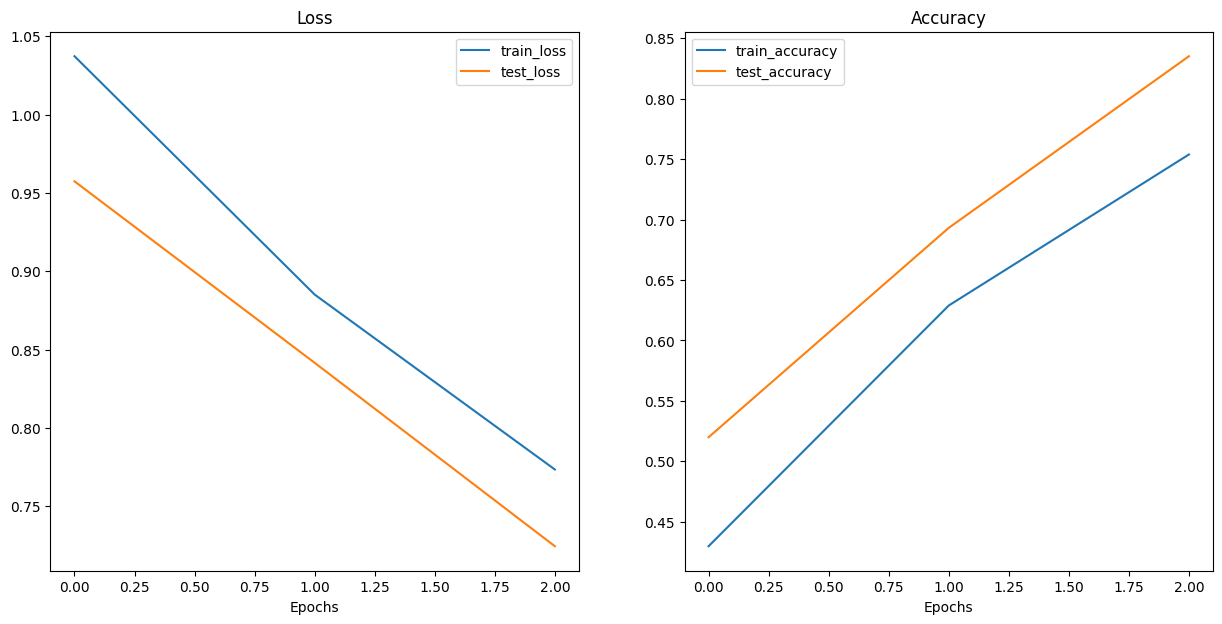

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_results)

### 4.2 Evulate using ConfusionMatrix

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

In [ ]:
# Make predictions
y_preds = []
model.eval()
with torch.inference_mode():
  for (X, y) in test_dataloader:
    X, y = X.to(device), y.to(device)

    y_logits = model(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    y_preds.append(y_pred)

In [ ]:
y_preds = torch.cat(y_preds)
y_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 2])

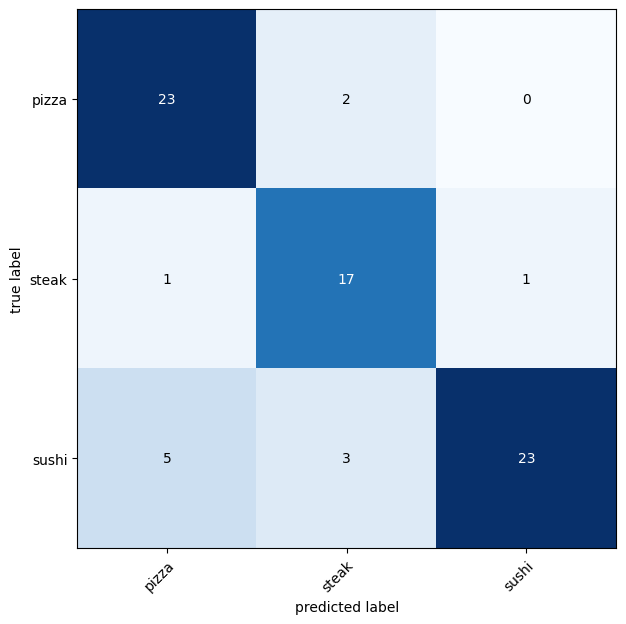

In [ ]:
# Get test data
test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
# Make confusion matrix
matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=3).to(device)
matrix_results = matrix(preds=y_preds,
                        target=torch.Tensor(test_data.targets).to(device))

# Plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=matrix_results.to("cpu").numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 5. Save model

### 5.1 Save model as .pth or .pt

In [ ]:
from going_modular import utils

In [ ]:
utils.save_model(model=model,
                 target_dir="models",
                 model_name="model.pt")

[INFO] Saving model to: models/model.pt
